<a href="https://colab.research.google.com/github/tvaditya/AndroidProjects/blob/master/%5BNLP8%5DTransformersPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 3.8 MB 30.6 MB/s 
     |████████████████████████████████| 596 kB 82.4 MB/s 
     |████████████████████████████████| 6.5 MB 77.9 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 895 kB 86.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 30.0 MB/s 
     |████████████████████████████████| 212 kB 53.9 MB/s 
     |████████████████████████████████| 1.1 MB 56.8 MB/s 
     |████████████████████████████████| 136 kB 71.9 MB/s 
     |████████████████████████████████| 127 kB 62.7 MB/s 
     |████████████████████████████████| 144 kB 76.9 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 271 kB 85.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urll

In [ ]:


import math
import os
import pickle
import re
from dataclasses import dataclass

import datasets
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tqdm.notebook import tqdm
from transformers import (AdamW, BertForSequenceClassification, BertTokenizer,
                          DataCollatorWithPadding,
                          get_linear_schedule_with_warmup)

datasets.logging.set_verbosity_error()



In [ ]:
from google.colab import drive

In [ ]:
drive.mount(('/content/drive'))

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
dft100 = pd.read_csv("/content/drive/My Drive/sentiment_data/Train100.csv", delimiter=";")
dft100.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1038907387523022848,FAV e falo de vocês por dm :),Sun Sep 09 21:49:57 +0000 2018,1,:)
1,1038907373010804737,"@lalenes_ O bom de lembrar é pra não repetir, ...",Sun Sep 09 21:49:54 +0000 2018,1,:)
2,1038907372679389185,vamos porquinhos !!! :D https://t.co/UFwKt1dCxe,Sun Sep 09 21:49:54 +0000 2018,1,:)
3,1038907369353355265,"Tenho raiva de vc por vc ser tão linda, eu me ...",Sun Sep 09 21:49:53 +0000 2018,1,:)
4,1038907325107634177,@Daniel_Albino Eu disse espectacular :),Sun Sep 09 21:49:42 +0000 2018,1,:)


In [ ]:
# dicio = {0: "Negativo", 1: "Positivo"}

In [ ]:
# dft100 = dft100.replace({"sentiment": dicio})

In [ ]:
dft100.shape

(100000, 5)

In [ ]:
dft100.sentiment.value_counts()

1    50000
0    50000
Name: sentiment, dtype: int64

In [ ]:
dft100.sentiment.unique()

array([1, 0])

In [ ]:
dftNeutralNews = pd.read_csv("/content/drive/My Drive/sentiment_data/TweetsNeutralNews.csv")
dftNeutralNews.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1038992008461930496,Esquerda e direita empatam na Suécia; ultranac...,Mon Sep 10 03:26:13 +0000 2018,Neutro,veja
1,1038873557902782465,Ao vivo: Estadão e TV Gazeta realizam terceiro...,Sun Sep 09 19:35:32 +0000 2018,Neutro,veja
2,1038869931398516736,FOTOS: Apoiadores de Jair Bolsonaro realizam a...,Sun Sep 09 19:21:07 +0000 2018,Neutro,veja
3,1038867128886198273,Barroso ameaça barrar propaganda se PT insisti...,Sun Sep 09 19:09:59 +0000 2018,Neutro,veja
4,1038859914339409920,Serena Williams é multada pelo comportamento d...,Sun Sep 09 18:41:19 +0000 2018,Neutro,veja


In [ ]:
dftNeutralNews.sentiment.unique()

array(['Neutro'], dtype=object)

In [ ]:
dftNeutralNews.shape

(37556, 5)

In [ ]:
dftTheme = pd.read_csv("/content/drive/My Drive/sentiment_data/TweetsWithTheme.csv")
dftTheme.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1026606627041026050,ela vendo a família :( FUGIDINHA VERA LÚCIA,Mon Aug 06 23:11:07 +0000 2018,Negativo,vera lucia :(
1,1026266117646561281,Eu odeio o fato que muito provavelmente meu vo...,Mon Aug 06 00:38:04 +0000 2018,Negativo,ciro :(
2,1025889796097564672,"Ciro ""mita"" tanto quanto aquele outro, não que...",Sat Aug 04 23:42:42 +0000 2018,Negativo,ciro :(
3,1026960047937646598,Raiva do Bolsonaro agora :),Tue Aug 07 22:35:30 +0000 2018,Positivo,bolsonaro :)
4,1026447105932623872,Reflexos da alienação petista comandada por Lu...,Mon Aug 06 12:37:15 +0000 2018,Negativo,lula :(


In [ ]:
dftTheme.shape

(61591, 5)

In [ ]:
dftTheme.sentiment.unique()

array(['Negativo', 'Positivo'], dtype=object)

In [ ]:
dftTheme.sentiment.value_counts()

Positivo    32744
Negativo    28847
Name: sentiment, dtype: int64

In [ ]:
dftHash = pd.read_csv("/content/drive/My Drive/sentiment_data/TweetsNeutralHash.csv")
dftHash.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1027376569449410562,@dilsonramoslima #Fato Acho que o Roger é um b...,Thu Aug 09 02:10:36 +0000 2018,Neutro,#fato
1,1026566106599833600,#NOVIDADE! @LATAM_BRA acaba de anunciar novo v...,Mon Aug 06 20:30:07 +0000 2018,Neutro,#novidade
2,1026445716808445952,Quando tem #novidade😆 tem @novafm103 na área! ...,Mon Aug 06 12:31:43 +0000 2018,Neutro,#novidade
3,1025980728356626434,@RiodeNojeira #Novidade Taí o sucesso dos filh...,Sun Aug 05 05:44:02 +0000 2018,Neutro,#novidade
4,1025531221978308608,"[Livro/Novidades] Segredos, uma história de Lu...",Fri Aug 03 23:57:51 +0000 2018,Neutro,#novidade


In [ ]:
dftHash.shape 

(15727, 5)

In [ ]:
dftHash.sentiment.unique()

array(['Neutro'], dtype=object)

In [ ]:
dicio = {'Neutro': 2, 'Negativo': 0, 'Positivo': 1}
df_list = [dftTheme, dftHash, dftNeutralNews]

In [ ]:
for df in df_list:
  df.replace({"sentiment": dicio}, inplace=True)

In [ ]:
for df in df_list:
  print(df.head(3))

                    id                                         tweet_text  \
0  1026606627041026050        ela vendo a família :( FUGIDINHA VERA LÚCIA   
1  1026266117646561281  Eu odeio o fato que muito provavelmente meu vo...   
2  1025889796097564672  Ciro "mita" tanto quanto aquele outro, não que...   

                       tweet_date  sentiment     query_used  
0  Mon Aug 06 23:11:07 +0000 2018          0  vera lucia :(  
1  Mon Aug 06 00:38:04 +0000 2018          0        ciro :(  
2  Sat Aug 04 23:42:42 +0000 2018          0        ciro :(  
                    id                                         tweet_text  \
0  1027376569449410562  @dilsonramoslima #Fato Acho que o Roger é um b...   
1  1026566106599833600  #NOVIDADE! @LATAM_BRA acaba de anunciar novo v...   
2  1026445716808445952  Quando tem #novidade😆 tem @novafm103 na área! ...   

                       tweet_date  sentiment query_used  
0  Thu Aug 09 02:10:36 +0000 2018          2      #fato  
1  Mon Aug 06 20:3

In [ ]:
dft100['origem'] = "train100"
dftHash['origem'] = "NeutralHash"
dftTheme['origem'] = "NoThemes"
dftNeutralNews['origem'] = "NeutralNews"

In [ ]:
df = pd.concat([dft100, dftTheme, dftHash, dftNeutralNews])
print(df.shape)
print(df.sentiment.value_counts())


(214874, 6)
1    82744
0    78847
2    53283
Name: sentiment, dtype: int64


In [ ]:
df['origem'] = df['origem'] + df['sentiment'].values.astype('str')

In [ ]:
df['origem'].head()

0    train1001
1    train1001
2    train1001
3    train1001
4    train1001
Name: origem, dtype: object

In [ ]:
df.isna().count().count()

6

In [ ]:
df = df.dropna()

In [ ]:
df.isna().count().count()

6

In [ ]:
# Limpeza de texto
import re

In [ ]:
def hashtag(text):
  hash = re.findall(r"#(\w+)", text)
  return hash

hashtag(" #blalbla")

['blalbla']

In [ ]:
def remove_username(text):
  clean_text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)
  return clean_text

remove_username('@Aditya')

''

In [ ]:
def remove_links_http(text):
  text = re.sub(r'http\S+','', text)
  # text = re.sub(r'https','', text)
  text = re.sub(r'bit.ly/\S+','', text)
  text = text.strip('[link]')

  return text

remove_links_http("http//:bla")

''

In [ ]:
def lower(text):
  return text.lower()

In [ ]:
# def remove_faces(text):
#   text = re.sub(r':[\)\(]+', '', text)
#   return text

In [ ]:
from nltk.tokenize import RegexpTokenizer

def remove_punct(text):
  token=RegexpTokenizer(r'\w+')#regex
  text = token.tokenize(text)
  text= " ".join(text)
  return text

remove_punct("Alo , 123 @123, @aaa aaa 123. Asasda1238 são bão aço y889. :) :( .")

'Alo 123 123 aaa aaa 123 Asasda1238 são bão aço y889'

In [ ]:
df['clean_tweet_text'] = df.tweet_text.apply(func=remove_links_http)
df['clean_tweet_text'] = df.clean_tweet_text.apply(func=remove_username)
df['clean_tweet_text'] = df.clean_tweet_text.apply(func=lower)
df['clean_tweet_text'] = df.clean_tweet_text.apply(func=remove_punct)

In [ ]:
df.head()

,id,tweet_text,tweet_date,sentiment,query_used,origem,clean_tweet_text
0,1038907387523022848,FAV e falo de vocês por dm :),Sun Sep 09 21:49:57 +0000 2018,1,:),train1001,fav e falo de vocês por dm
1,1038907373010804737,"@lalenes_ O bom de lembrar é pra não repetir, ...",Sun Sep 09 21:49:54 +0000 2018,1,:),train1001,o bom de lembrar é pra não repetir com a próxi...
2,1038907372679389185,vamos porquinhos !!! :D https://t.co/UFwKt1dCxe,Sun Sep 09 21:49:54 +0000 2018,1,:),train1001,vamos porquinhos d
3,1038907369353355265,"Tenho raiva de vc por vc ser tão linda, eu me ...",Sun Sep 09 21:49:53 +0000 2018,1,:),train1001,tenho raiva de vc por vc ser tão linda eu me a...
4,1038907325107634177,@Daniel_Albino Eu disse espectacular :),Sun Sep 09 21:49:42 +0000 2018,1,:),train1001,eu disse espectacular


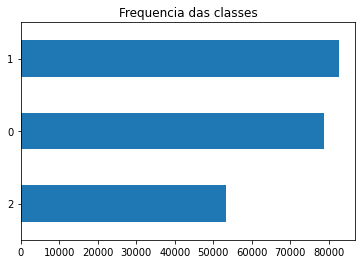

In [ ]:
import matplotlib.pyplot as plt
df['sentiment'].value_counts(ascending=True).plot.barh()
plt.title("Frequencia das classes")
plt.show();

In [ ]:
df["split_words"] = df["clean_tweet_text"].str.split()
df["split_words"][:5]

0                   [fav, e, falo, de, vocês, por, dm]
1    [o, bom, de, lembrar, é, pra, não, repetir, co...
2                               [vamos, porquinhos, d]
3    [tenho, raiva, de, vc, por, vc, ser, tão, lind...
4                            [eu, disse, espectacular]
Name: split_words, dtype: object

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


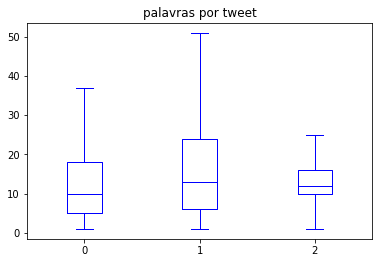

In [ ]:
df["palavras por tweet"] = df["split_words"].apply(len)
df.boxplot("palavras por tweet",
           by="sentiment",
           grid=False,
           showfliers=False,
           color="blue")
plt.suptitle("")
plt.xlabel("")
plt.show();

In [ ]:
df["palavras por tweet"].describe()

count    214874.000000
mean         14.972668
std          11.240445
min           0.000000
25%           7.000000
50%          12.000000
75%          19.000000
max          84.000000
Name: palavras por tweet, dtype: float64

In [ ]:
df_new = df[df["palavras por tweet"]==1]
print(df_new.shape)
df_new.head()

(3280, 9)


,id,tweet_text,tweet_date,sentiment,query_used,origem,clean_tweet_text,split_words,palavras por tweet
35,1038906785829187585,Amigos :))) https://t.co/ZC0YU8l1ii,Sun Sep 09 21:47:34 +0000 2018,1,:),train1001,amigos,[amigos],1
96,1038905773827473409,@hulya1299 @ismaillacin Certamente :),Sun Sep 09 21:43:33 +0000 2018,1,:),train1001,certamente,[certamente],1
195,1038903805524561921,@Jokunle @tecofcof Brasil :),Sun Sep 09 21:35:43 +0000 2018,1,:),train1001,brasil,[brasil],1
196,1038903792673193984,@gean_dreson brigada!!! :))),Sun Sep 09 21:35:40 +0000 2018,1,:),train1001,brigada,[brigada],1
276,1038901938383998980,@cagool_ @heey_bruuhh Perdeu :),Sun Sep 09 21:28:18 +0000 2018,1,:),train1001,perdeu,[perdeu],1


In [ ]:
df.tail(10)

,id,tweet_text,tweet_date,sentiment,query_used,origem,clean_tweet_text,split_words,palavras por tweet
37546,1047913244202082308,Familiares de vítimas da Chapecoense vão à Bol...,Thu Oct 04 18:16:01 +0000 2018,2,exame,NeutralNews2,familiares de vítimas da chapecoense vão à bol...,"[familiares, de, vítimas, da, chapecoense, vão...",11
37547,1047894920688594944,"Alckmin cogita união “Alcirina”, mas diz não a...",Thu Oct 04 17:03:12 +0000 2018,2,exame,NeutralNews2,alckmin cogita união alcirina mas diz não abri...,"[alckmin, cogita, união, alcirina, mas, diz, n...",11
37548,1047882576650756096,Site #EXAME recebeu mais de 25 milhões de visi...,Thu Oct 04 16:14:09 +0000 2018,2,exame,NeutralNews2,site exame recebeu mais de 25 milhões de visit...,"[site, exame, recebeu, mais, de, 25, milhões, ...",11
37549,1047858617460973568,Atores reproduzem falas do debate presidencial...,Thu Oct 04 14:38:57 +0000 2018,2,exame,NeutralNews2,atores reproduzem falas do debate presidencial...,"[atores, reproduzem, falas, do, debate, presid...",11
37550,1048004843728764929,Manter as florestas é a forma mais eficiente d...,Fri Oct 05 00:20:00 +0000 2018,2,jornaloglobo,NeutralNews2,manter as florestas é a forma mais eficiente d...,"[manter, as, florestas, é, a, forma, mais, efi...",15
37551,1047976013655887878,Datafolha: Flávio Bolsonaro tem 30% e Cesar Ma...,Thu Oct 04 22:25:26 +0000 2018,2,jornaloglobo,NeutralNews2,datafolha flávio bolsonaro tem 30 e cesar maia...,"[datafolha, flávio, bolsonaro, tem, 30, e, ces...",15
37552,1047924318733254658,China plantou chips em computadores para espio...,Thu Oct 04 19:00:01 +0000 2018,2,jornaloglobo,NeutralNews2,china plantou chips em computadores para espio...,"[china, plantou, chips, em, computadores, para...",13
37553,1047873981443919873,"Vitinho reaparece, e Dorival diz que tem Flame...",Thu Oct 04 15:40:00 +0000 2018,2,jornaloglobo,NeutralNews2,vitinho reaparece e dorival diz que tem flamen...,"[vitinho, reaparece, e, dorival, diz, que, tem...",13
37554,1047988225069932544,"Daqui a pouco, o G1 transmite o debate dos can...",Thu Oct 04 23:13:58 +0000 2018,2,g1,NeutralNews2,daqui a pouco o g1 transmite o debate dos cand...,"[daqui, a, pouco, o, g1, transmite, o, debate,...",12
37555,1049349212163342336,Percentual de mulheres eleitas para a Câmara c...,Mon Oct 08 17:22:02 +0000 2018,2,folha,NeutralNews2,percentual de mulheres eleitas para a câmara c...,"[percentual, de, mulheres, eleitas, para, a, c...",12


In [ ]:
from sklearn.utils import shuffle

In [ ]:
df = shuffle(df, random_state=2022).reset_index(drop=True)
# df.head(10)

In [ ]:
# df.tail(10)

In [ ]:
df.shape

(214874, 9)

In [ ]:
df.columns

Index(['id', 'tweet_text', 'tweet_date', 'sentiment', 'query_used', 'origem',
       'clean_tweet_text', 'split_words', 'palavras por tweet'],
      dtype='object')

In [ ]:
df_prep = df

In [ ]:
df_prep = df_prep.drop(['id','tweet_text','tweet_date', 'query_used','palavras por tweet'], axis=1)
df_prep.head()

,sentiment,origem,clean_tweet_text,split_words
0,2,NeutralNews2,cade condena rodrimar a pagar r 972 mil por co...,"[cade, condena, rodrimar, a, pagar, r, 972, mi..."
1,0,train1000,meudeusss,[meudeusss]
2,1,NoThemes1,dr rey formado em ciências políticas pela univ...,"[dr, rey, formado, em, ciências, políticas, pe..."
3,0,NoThemes0,mas haddad não é ladrão é melhor não usar fake...,"[mas, haddad, não, é, ladrão, é, melhor, não, ..."
4,2,NeutralHash2,colocar calcinha de renda e ficar admirando a ...,"[colocar, calcinha, de, renda, e, ficar, admir..."


In [ ]:
# df_train = df_prep.iloc[:192873,:]
# df_test = df_prep.iloc[192873:,:]

In [ ]:
 from sklearn.model_selection import train_test_split

In [ ]:
def create_splits(data):
    test_validation_size = int(0.01*data.shape[0])
    train_validation, test = train_test_split(
        data, 
        test_size=test_validation_size, 
        random_state=2022, 
        stratify=data['origem'])
    train, validation = train_test_split(
        train_validation, 
        test_size=test_validation_size, 
        random_state=2022, 
        stratify=train_validation['origem'])
    return train, validation, test



In [ ]:
train, validation, test = create_splits(df_prep)
print('Training samples:  ', train.shape[0])
print('Validation samples:', validation.shape[0])
print('Test samples:      ', test.shape[0])


Training samples:   210578
Validation samples: 2148
Test samples:       2148


In [ ]:
train.columns

Index(['sentiment', 'origem', 'clean_tweet_text', 'split_words'], dtype='object')

In [ ]:
train.rename(columns={'sentiment':'labels', 'split_words': 'texts'}, inplace=True)
train.columns

Index(['labels', 'origem', 'clean_tweet_text', 'texts'], dtype='object')

In [ ]:
test.rename(columns={'sentiment':'labels', 'split_words': 'texts'}, inplace=True)
test.columns

Index(['labels', 'origem', 'clean_tweet_text', 'texts'], dtype='object')

In [ ]:
validation.rename(columns={'sentiment':'labels', 'split_words': 'texts'}, inplace=True)
validation.columns

Index(['labels', 'origem', 'clean_tweet_text', 'texts'], dtype='object')

In [ ]:

train_pt = train.copy()
validation_pt = validation.copy()
test_pt = test.copy()

In [ ]:
test_pt.head()

,labels,origem,clean_tweet_text,texts
73524,0,train1000,hj eh meu aniversario caraio gt,"[hj, eh, meu, aniversario, caraio, gt]"
143546,0,NoThemes0,porem no 2 turno se n tiver ciro meu pai vira ...,"[porem, no, 2, turno, se, n, tiver, ciro, meu,..."
13365,1,train1001,no seu lugar preferiria o siqueira ao envez do...,"[no, seu, lugar, preferiria, o, siqueira, ao, ..."
193961,1,train1001,e sem voto electrónico,"[e, sem, voto, electrónico]"
192082,0,NoThemes0,eu espero que o amoedo consiga ir ao debate da...,"[eu, espero, que, o, amoedo, consiga, ir, ao, ..."


In [ ]:
test_pt = test_pt.drop(['origem'], axis=1)
train_pt = train_pt.drop(['origem'], axis=1)
validation_pt = validation_pt.drop(['origem'], axis=1)

In [ ]:
train_pt.head(3)

,labels,clean_tweet_text,texts
50690,0,ão façam panelinhas entre fcs famosos lá vai d...,"[ão, façam, panelinhas, entre, fcs, famosos, l..."
193351,1,minha vida é resolver problema evitar novos e ...,"[minha, vida, é, resolver, problema, evitar, n..."
60996,0,é triste a quantidade de gente que vai pra urn...,"[é, triste, a, quantidade, de, gente, que, vai..."


In [ ]:
validation_pt.head(3)

,labels,clean_tweet_text,texts
46612,0,sim no pior dos mundos esse é o cenário mas ai...,"[sim, no, pior, dos, mundos, esse, é, o, cenár..."
191575,0,não tenho adesivo do ciro to troste,"[não, tenho, adesivo, do, ciro, to, troste]"
18751,2,gt eu tiro todos os prefeitos diz beto richa n...,"[gt, eu, tiro, todos, os, prefeitos, diz, beto..."


In [ ]:
test_pt.head(3)

,labels,clean_tweet_text,texts
73524,0,hj eh meu aniversario caraio gt,"[hj, eh, meu, aniversario, caraio, gt]"
143546,0,porem no 2 turno se n tiver ciro meu pai vira ...,"[porem, no, 2, turno, se, n, tiver, ciro, meu,..."
13365,1,no seu lugar preferiria o siqueira ao envez do...,"[no, seu, lugar, preferiria, o, siqueira, ao, ..."


In [ ]:
train_pt.columns, test_pt.columns, validation_pt.columns

(Index(['labels', 'clean_tweet_text', 'texts'], dtype='object'),
 Index(['labels', 'clean_tweet_text', 'texts'], dtype='object'),
 Index(['labels', 'clean_tweet_text', 'texts'], dtype='object'))

In [ ]:
train_pt.drop('clean_tweet_text', axis=1, inplace=True)
print(train_pt.head())
test_pt.drop('clean_tweet_text', axis=1, inplace=True)
print(test_pt.head())
validation_pt.drop('clean_tweet_text', axis=1, inplace=True)
print(validation_pt.head())

        labels                                              texts
50690        0  [ão, façam, panelinhas, entre, fcs, famosos, l...
193351       1  [minha, vida, é, resolver, problema, evitar, n...
60996        0  [é, triste, a, quantidade, de, gente, que, vai...
109369       0                                      [fudeu, miga]
172173       1  [o, que, é, afinal, empreender, adoro, esta, d...
        labels                                              texts
73524        0             [hj, eh, meu, aniversario, caraio, gt]
143546       0  [porem, no, 2, turno, se, n, tiver, ciro, meu,...
13365        1  [no, seu, lugar, preferiria, o, siqueira, ao, ...
193961       1                        [e, sem, voto, electrónico]
192082       0  [eu, espero, que, o, amoedo, consiga, ir, ao, ...
        labels                                              texts
46612        0  [sim, no, pior, dos, mundos, esse, é, o, cenár...
191575       0        [não, tenho, adesivo, do, ciro, to, troste]
18751     

In [ ]:
train_pt.to_csv("train_pt.csv", index=False)
validation_pt.to_csv("validation_pt.csv", index=False)
test_pt.to_csv("test_pt.csv", index=False)

In [ ]:
df = pd.read_csv("train_pt.csv")
df.head()

,labels,texts
0,0,"['ão', 'façam', 'panelinhas', 'entre', 'fcs', ..."
1,1,"['minha', 'vida', 'é', 'resolver', 'problema',..."
2,0,"['é', 'triste', 'a', 'quantidade', 'de', 'gent..."
3,0,"['fudeu', 'miga']"
4,1,"['o', 'que', 'é', 'afinal', 'empreender', 'ado..."


In [ ]:
del df
# Lembrar de criar uma função para as celulas acima


In [ ]:
import datasets

In [ ]:
def compute_metrics(preds, labels):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def send_inputs_to_device(inputs, device):
    return {key:tensor.to(device) for key, tensor in inputs.items()}

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [ ]:
def build_dataset(tokenizer, splits):
    train, validation, test = splits

    dataset = datasets.load_dataset('csv', data_files={'train': 'train_pt.csv',
                                                       'validation':'validation_pt.csv',
                                                       'test': 'test_pt.csv'})
    # dataset = dataset.map(lambda example: {'unbiased_text': re.sub(r':[\)\(]+', '', example['texts'])}, batched=False)
    dataset = dataset.map(lambda examples: tokenizer(examples['texts']), batched=True)
    # dataset = dataset.map(lambda example: {'labels': 1 if example['sentiment'] == 'Positivo' else 0}, batched=False)
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    
    return dataset



In [ ]:
dataset = build_dataset(tokenizer, (train, validation, test))

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1ac15e1ad57a81f2/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'texts', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 210578
    })
    validation: Dataset({
        features: ['labels', 'texts', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2148
    })
    test: Dataset({
        features: ['labels', 'texts', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2148
    })
})

In [ ]:
dataset['train']['labels'][:5]

tensor([0, 1, 0, 0, 1])

In [ ]:
dataset['train']['input_ids'][:5]

[tensor([  101,   164,   112,   100,   112,   117,   112, 18511, 22287,   112,
           117,   112,  9196, 15249, 13808, 22281,   112,   117,   112,   420,
           112,   117,   112,   153, 18980,   112,   117,   112,  8801,   112,
           117,   112,  2920,   112,   117,   112,  2541,   112,   117,   112,
          4314,   112,   117,   112,   260,   112,   117,   112,  1028,   112,
           117,   112,  3748,  2076,   112,   117,   112,   179,   112,   117,
           112,   506,   112,   117,   112, 15480, 22281,   112,   117,   112,
         12448,   112,   117,   112,  2779,   112,   117,   112,   240,   112,
           117,   112,  1416,   112,   117,   112,   346,   112,   117,   112,
           311,   112,   117,   112,  1114,   210,   112,   117,   112, 15480,
           112,   166,   102]),
 tensor([  101,   164,   112,  7122,   112,   117,   112,  1069,   112,   117,
           112,   253,   112,   117,   112,  8416,   112,   117,   112,  3350,
           112,   11

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))
validation_loader = torch.utils.data.DataLoader(dataset['validation'], batch_size=32, collate_fn=DataCollatorWithPadding(tokenizer))
test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=32, collate_fn=DataCollatorWithPadding(tokenizer))

In [ ]:
num_epochs = 1
num_warmup_steps = 5000

model = BertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.train().to(device)

optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_epochs*len(train_loader))

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [ ]:
def predict(model, validation_loader, device):
    with torch.no_grad():
        model.eval()
        preds = []
        labels = []
        validation_losses = []
        for inputs in validation_loader:
            labels.append(inputs['labels'].numpy())
            
            inputs = send_inputs_to_device(inputs, device)
            loss, scores = model(**inputs)[:2]
            validation_losses.append(loss.cpu().item())

            _, classifications = torch.max(scores, 1)
            preds.append(classifications.cpu().numpy())
        model.train()
    return np.concatenate(preds), np.concatenate(labels)

In [ ]:
epoch_bar = tqdm(range(num_epochs))
loss_acc = 0
alpha = 0.95
for epoch in epoch_bar:
    batch_bar = tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=len(train_loader))
    for idx, inputs in batch_bar:
        inputs = send_inputs_to_device(inputs, device)
        optimizer.zero_grad()
        loss, logits = model(**inputs)[:2]
        
        loss.backward()
        optimizer.step()
        
        # calculate a simplified ewma to the loss
        if epoch == 0 and idx == 0:
            loss_acc = loss.cpu().item()
        else:
            loss_acc = loss_acc * alpha + (1-alpha) * loss.cpu().item()
        
        batch_bar.set_postfix(loss=loss_acc)
        
        if idx%5000 == 0:
            preds, labels = predict(model, validation_loader, device)
            metrics = compute_metrics(preds, labels)
            print(metrics)
            

        scheduler.step()
    # os.makedirs('/content/drive/My Drive/kaggle/working/checkpoints/epoch'+str(epoch))
    # model.save_pretrained('/content/drive/My Dirve/kaggle/working/checkpoints/epoch'+str(epoch))  



  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/13162 [00:00<?, ?it/s]

{'accuracy': 0.25186219739292365, 'f1': 0.25186219739292365, 'precision': 0.25186219739292365, 'recall': 0.25186219739292365}
{'accuracy': 0.8486964618249534, 'f1': 0.8486964618249534, 'precision': 0.8486964618249534, 'recall': 0.8486964618249534}
{'accuracy': 0.8645251396648045, 'f1': 0.8645251396648045, 'precision': 0.8645251396648045, 'recall': 0.8645251396648045}


In [ ]:
model.save_pretrained('/content/drive/My Drive/kaggle/sentiment_data'+str(epoch)) 

In [ ]:
preds, labels = predict(model, test_loader, device)
metrics = compute_metrics(preds, labels)
print(metrics)

{'accuracy': 0.8505586592178771, 'f1': 0.8505586592178771, 'precision': 0.8505586592178771, 'recall': 0.8505586592178771}


In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
# imdb_dataset = datasets.load_dataset('csv', data_files={'test': '/kaggle/input/imdb-ptbr/imdb-reviews-pt-br.csv'})
# imdb_dataset = imdb_dataset.map(lambda examples: tokenizer(examples['text_pt']), batched=True)
# imdb_dataset = imdb_dataset.filter(lambda example: len(example['input_ids']) <= 512)
# imdb_dataset = imdb_dataset.map(lambda example: {'labels': 1 if example['sentiment'] == 'pos' else 0}, batched=False)

# imdb_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

# imdb_loader = torch.utils.data.DataLoader(imdb_dataset['test'], batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))

In [ ]:
dfimdb = pd.read_csv("/content/drive/My Drive/sentiment_data/imdb-reviews-pt-br.csv", delimiter=",")
dfimdb.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [ ]:
dfimdb.sentiment.unique()

array(['neg', 'pos'], dtype=object)

# RASCUNHO 1

In [ ]:
# train = create_batch('train', 'train_pt.csv')
# validation = create_batch('validation', 'validation_pt.csv')
# test = create_batch('test', 'test_pt.csv')

In [ ]:
train

In [ ]:
# train['train']['text'][:5]

In [ ]:
# train['train']['label'][:5]

In [ ]:
# test

In [ ]:
# test['test']['label'][:5]

In [ ]:
# train.update(validation)

In [ ]:
# train.update(test)

In [ ]:
# train


In [ ]:
# del test
# del validation

In [ ]:
# dataset = build_dataset(tokenizer, (train, validation, test))
# ds = train

In [ ]:
# ds

In [ ]:
# ds['train'].column_names

In [ ]:
# # dataset['train']['__index_level_0__'][:5]
# dataset = {}

In [ ]:
# dataset['train'] = tokenize(ds['train'])


In [ ]:
# dataset['validation'] = tokenize(ds['validation'])

In [ ]:
# dataset['test'] = tokenize(ds['test'])

In [ ]:
# dataset['train'][0]

# RASCUNHOS


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
                         # <--- This works
# tokenizer.encode(["hello"])                                   # <--- This throws the below shown stack trace
# tokenizer.encode(["dette", "er", "en", "sø"])      

In [ ]:
tokenizer.encode("dinheiro") 

In [ ]:
tokenizer.encode(["Olá", "mundo"], is_split_into_words=True) 

In [ ]:
tokenizer.encode(["dinheiro"], is_split_into_words=True) 

In [ ]:
tokenizer.encode(["dinheiro"][0]) 

In [ ]:
tokenizer.encode(['  '], is_split_into_words=True) 